In [1]:
import os, sys, shutil
sys.path.insert(0,"/home/hschia/data/love")
sys.path.insert(-1, "/home/hschia/PE/gw_detection_ias")

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import interpolate
from importlib import reload
import multiprocess, json
import time
import pickle
import pandas as pd
import glob
from pprint import pprint

import template_bank_generator_love as tg
import params_love as params
import loveNum_waveform_merger as lovewf
import utils_love as utils

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

# %matplotlib widget
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 5)

Using FMAX_OVERLAP: 512


In [2]:
DIR = '/home/hschia/data/love'
PSD_DIR = 'psd_comparison'

In [7]:
# ASD estimation, file has already been saved for O3a so no need of running this section (unless you want to remake the file)
# Triggerlist filenames, we'll get asdfuncs from them
run = 'O3a'
asd_file = os.path.join(DIR, PSD_DIR, f'ref_asd_{run}_median.npy')

if run == 'O1':
    fnames = [f for f in glob.glob('/data/bzackay/GW/OutputDir/O1_Mon_Apr_8_13_36O2_BBH_2_multibank_bank_0/*.json') # Random triggers file
            if ('H1' in f or 'L1' in f)]
elif run == 'O2':
    fnames = [f for f in glob.glob('/data/bzackay/GW/OutputDir/O2_Sat_Mar_9_22_16O2_BBH_1_multibank_bank_0/*.json') # Random triggers file
            if ('H1' in f or 'L1' in f)]
elif run == 'O3a':
    fnames = [f for f in glob.glob('/data/bzackay/GW/O3Events/*/*.json')
              if ('H1' in f or 'L1' in f) and not 'GW190425' in f]
elif run == 'O3b':
    fnames = [f for f in glob.glob('/scratch/lustre/srolsen/GW/OutputDir/O3b_Tue_Mar_22_19_08O3a_BBH_2_multibank_bank_1/*.json') # Random triggers file
            if ('H1' in f or 'L1' in f)]

In [8]:
n_files = min(100, len(fnames))
f_full = np.geomspace(10, 1e3, 1000)  # (asd below params.FMIN_PSD=15Hz is inf, cf. d_ops.data_to_asdfunc); 
percentile = 50

import triggers_single_detector
asds = np.array([triggers_single_detector.TriggerList.from_json(fname).asdfunc(f_full)
                 for fname in np.random.choice(fnames, n_files, replace=False)])
ref_asd = np.percentile(asds, percentile,  axis=0)

# Occasionally need to convert nan to inf for good behaviour later
ref_asd = np.nan_to_num(ref_asd, nan=np.inf)

if not os.path.isfile(asd_file):
    np.save(asd_file, np.vstack((f_full, ref_asd)))
else:
    print(f"File {asd_file} exists, didn't overwrite")

## Load test asds

In [9]:
asd_o1 = np.load('/home/hschia/data/love/psd_comparison/ref_asd_O1_median.npy')
asd_o2 = np.load('/home/hschia/data/love/psd_comparison/ref_asd_O2_median.npy')
asd_o3a = np.load('/home/hschia/data/love/psd_comparison/ref_asd_O3a_median.npy')
# asd_o3b = np.load('/home/hschia/data/love/psd_comparison/ref_asd_O3b_test.npy')

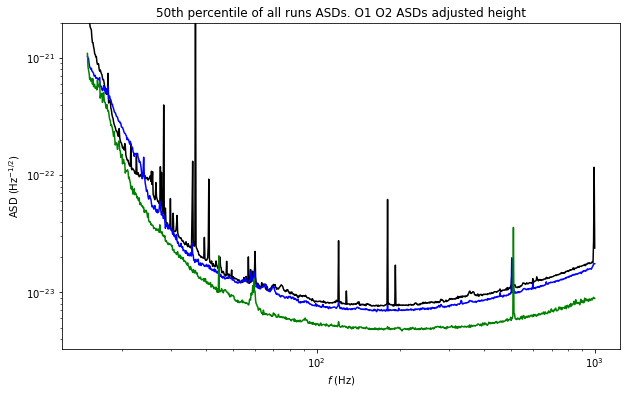

In [13]:
plt.figure(figsize=(10,6))
plt.loglog(f_full, asd_o1[1], 'k', lw=1.5)
plt.loglog(f_full, asd_o2[1], 'b', lw=1.5)
plt.loglog(f_full, asd_o3a[1], 'g', lw=1.5)
# plt.loglog(f_full, asd_o3b[1], 'r', lw=1.5, alpha=0.5)
plt.title(f'{percentile}th percentile of all runs ASDs. O1 O2 ASDs adjusted height')
plt.xlabel(r'$f$ (Hz)')
plt.ylabel(r'ASD (Hz$^{-1/2}$)')
plt.ylim(top=2e-21);

In [ ]:
# TODO: Test effectualness on these PSDs